# Iterative Dichotomiser 3 (ID3) 

## Summary:

- [x] Implementation of the original ID3 algorithm
- [x] Performance analysis using k-fold Cross-Validation
- [x] Comparison of accuracy vs. dataset size

## Implementation

### Libraries and auxiliary functions

In [1]:
from IPython.display import Image, display
import pandas as pd
import numpy as np
import pydot
import os

cwd = os.getcwd()
data_path = f'{cwd}/data/'

In [2]:
class Tree_printer:
    def __init__(self, tree):    
        self.tree = tree
        self.graph = pydot.Dot(graph_type='digraph', strict=True)
        
    def draw(self, parent_name, child_name):
        edge = pydot.Edge(parent_name, child_name)
        self.graph.add_edge(edge)
            
    def visit(self, node, parent=None):
        for k,v in node.items():
            if isinstance(v, dict):
                if parent:
                    self.draw(parent, k)
                self.visit(v, k)
            else:
                self.draw(parent, k)
                self.draw(k, k+'_'+v)

    def view_pydot(self):
        self.visit(self.tree)
        plt = Image(self.graph.create_png())
        display(plt)

### Main

In [3]:
class ID3_class:
    def __init__(self, dataset):
        self.df = dataset
        self.class_label = self.df.keys()[-1]
        self.class_values = self.df[self.class_label].unique()

    '''Total entropy H(T) '''
    def Total_entropy(self, df):
        entropy = 0
        for value in self.class_values:
            entropy += -df[self.class_label].value_counts()[value]/len(df[self.class_label])*np.log2(df[self.class_label].value_counts()[value]/len(df[self.class_label]))
        return entropy

    '''Conditional entropy per attribute-value H(T|a=v)'''
    def Conditional_entropy(self, df, attribute, attribute_value):
        entropy = 0
        eps = np.finfo(float).eps
        for i_class in self.class_values:
            num = len(df[attribute][df[attribute]==attribute_value][df[self.class_label] ==i_class])
            den = len(df[attribute][df[attribute]==attribute_value])
            entropy += -num/(den+eps)*np.log2(num/(den+eps)+eps)
        return entropy

    '''Information gain per attribute I(a) = H(T) - Sum P(a)H(T|a=v)'''
    def Information_gain(self, df, attribute):
        attributes = df[attribute].unique()    
        information_gain = self.Total_entropy(df)
        for attribute_value in attributes:
            entropy = self.Conditional_entropy(df, attribute, attribute_value)
            probability = len(df[attribute][df[attribute]==attribute_value])/len(df)
            information_gain += -probability*entropy
        return information_gain

    '''Attribute with highest information gain I(a)'''
    def Best_attribute(self, df):
        gains = []
        for attribute in df.keys()[:-1]:
            gains.append(self.Information_gain(df,attribute))
        return df.keys()[:-1][np.argmax(gains)]

    '''Create tree'''
    def Create_tree(self, df=None):
        attribute = self.Best_attribute(df)    
        attribute_values = np.unique(df[attribute])
        tree={}
        tree[attribute] = {}
        for value in attribute_values:
            subtable = df[df[attribute] == value].reset_index(drop=True)
            clValue, counts = np.unique(subtable[self.class_label],return_counts=True)                        
            if len(counts)==1:
                tree[attribute][value] = clValue[0]         
            else:        
                tree[attribute][value] = self.Create_tree(subtable)  
        return tree

    '''Predict class from instance'''
    def Predict(self, tree, instance):
        if not isinstance(tree, dict): 
            return tree 
        else:
            root_node = next(iter(tree)) 
            feature_value = instance[root_node] 
            if feature_value in tree[root_node]: 
                return self.Predict(tree[root_node][feature_value], instance) 
            else:
                return None
            
    '''Estimate average accuracy'''
    def Evaluate(self, tree, df_test):
        correct_preditct = 0
        wrong_preditct = 0
        for index, row in df_test.iterrows():
            result = self.Predict(tree, df_test.iloc[index]) 
            if result == df_test[self.class_label].iloc[index]:
                correct_preditct += 1 
            else:
                wrong_preditct += 1
        accuracy = correct_preditct / (correct_preditct + wrong_preditct) 
        return accuracy

## Datasets

#### D1 Play Tennis

In [4]:
D1_path = '/test/Training_PlayTennis.csv'
df_test = pd.read_csv("/home/jhermosilla/Documents/GitHub/ID3/data/test/Test_PlayTennis.csv") 
df_train = pd.read_csv(data_path + D1_path) 

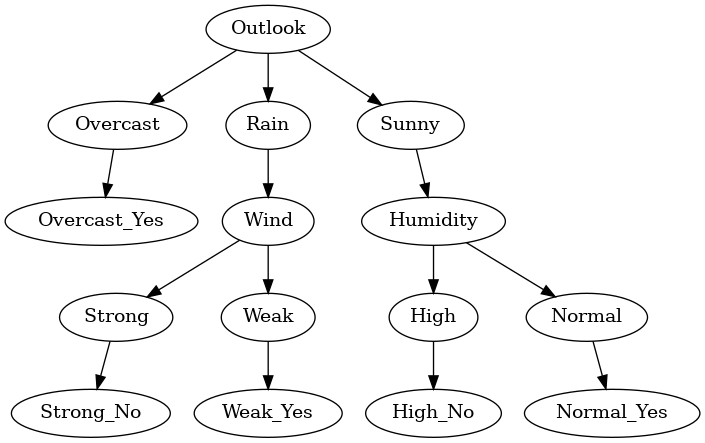

1.0


In [5]:
D1 = ID3_class(df_train)
D1_tree = D1.Create_tree(df_train)
D1_accuracy = D1.Evaluate(D1_tree, df_test)
D1_display = Tree_printer(D1_tree)
D1_display.view_pydot()
print(D1_accuracy)